In [60]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

import os
import warnings

In [4]:
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.set_index('id' , drop = True)
test = test.set_index('id' , drop = True)

In [5]:
y = train['target']
train = train.drop(['target'] , axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 587.9 KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19750 entries, 250 to 19999
Columns: 300 entries, 0 to 299
dtypes: float64(300)
memory usage: 45.4 MB


In [7]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [8]:
scaler = RobustScaler()
train_ = scaler.fit_transform(train)
test_ = scaler.transform(test)

In [59]:
clf2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize=False).fit(train_, y)
scores = cross_val_score(clf2, train_, y, cv=10, scoring='roc_auc')
print(scores)
avg_score = abs(np.mean(scores))
print(avg_score)

[0.71929825 0.83333333 0.45333333 0.71428571 0.8961039  0.51388889
 0.58333333 0.70833333 0.59722222 0.55769231]
0.6576824608140397


In [61]:
clf2.fit(train_, y)
ans = clf2.predict(test_) # clf2.predict_proba(test_)
# print(sum((ans > 0.5) == True))

In [101]:
plt.figure()
np.random.seed(0)

<Figure size 432x288 with 0 Axes>

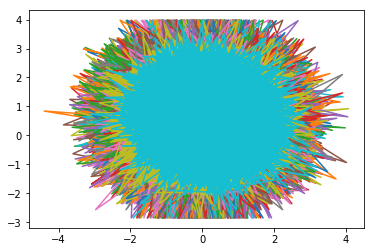

In [102]:
for _ in range(1): 
    clf2.fit(train_, y)
    plt.plot(test_, clf2.predict(test_)) 

In [91]:
clf3 = GaussianNB().fit(train_, y)
scores = cross_val_score(clf3, train_, y, cv=10)
print(scores)
avg_cv_acc = abs(np.mean(scores))
print(avg_cv_acc)

[0.72 0.6  0.64 0.72 0.84 0.72 0.72 0.68 0.68 0.68]
0.7


In [92]:
ans3 = clf3.predict(test_)
ans3

array([1., 1., 1., ..., 1., 1., 0.])

In [13]:
import csv
csvData = [['id', 'target']]
for i in range(len(ans3)):
    csvData.append([str(i+250),str(int(ans3[i]))])

with open('GaussianNB.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

In [40]:
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)
scaler = StandardScaler()

In [46]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            y_pred = model.predict_proba(X_test)[:, 1]

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, prediction, scores

In [122]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

parameter_grid = {'alpha': [0.0001, 0.001, 1, 2, 10, 20, 50, 100, 1000]
                 }

grid_search = GridSearchCV(bnb, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
bnb = BernoulliNB(**grid_search.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(train_, test_, y, params=None, model_type='sklearn', model=bnb)

Best score: 0.6872
Best parameters: {'alpha': 1}


In [124]:
for i in grid_search.cv_results_['params']:
    print(i, end=', ')
    bnb = BernoulliNB(**i)
    oof_bnb, prediction_bnb, scores_bnb = train_model(train_, test_, 
                                                      y, params=None, 
                                                      model_type='sklearn', 
                                                      model=bnb)

{'alpha': 0.0001}, CV mean score: 0.5881, std: 0.1500.
{'alpha': 0.001}, CV mean score: 0.5881, std: 0.1500.
{'alpha': 1}, CV mean score: 0.5881, std: 0.1500.
{'alpha': 2}, CV mean score: 0.5850, std: 0.1453.
{'alpha': 10}, CV mean score: 0.5775, std: 0.1417.
{'alpha': 20}, CV mean score: 0.5919, std: 0.1286.
{'alpha': 50}, CV mean score: 0.5969, std: 0.1328.
{'alpha': 100}, CV mean score: 0.5837, std: 0.1294.
{'alpha': 1000}, CV mean score: 0.5000, std: 0.0000.


In [125]:
ret = [0.0] * 19750
for i, pre in enumerate(prediction_bnb):
    if pre >= 0.5:
        ret[i] = 1.0
    else:
        ret[i] = 0.0

In [89]:
import csv
csvData = [['id', 'target']]
for i in range(len(ret)):
    csvData.append([str(i+250),str(int(ret[i]))])

with open('BernoulliNB.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()